# Synthetic Financial Datasets For Fraud Detection

## Motivation

This notebook is my excercise after learning Introduction Into Machine Learning book published by O'REILLY. The implementation on this notebook are data analysis with an imbalaced dataset, decomposisition methods, feature engineeing, and parameter search.

## Headers

This is a sample of 1 row with headers explanation:

1, PAYMENT, 1060.31, C429214117, 1089.0, 28.69, M1591654462, 0.0, 0.0, 0, 0

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount -
amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud (Target) - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [1]:
# need mglearn to show some plots
# !pip install mglearn

In [2]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import mglearn

In [3]:
transactions = pd.read_csv('fraud_data.csv')
transactions.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Data Analysis

In [3]:
# checking the distribution of isFraud
# that's a very small amout of fraud
fraud_compare = transactions['isFraud'].value_counts()
print("Valid transaction {:.3f}%".format(fraud_compare[0] / transactions.shape[0] * 100))
print("Fraud transaction {:.3f}%".format(fraud_compare[1] / transactions.shape[0] * 100))
print("Total data        ", transactions.shape[0])

Valid transaction 99.871%
Fraud transaction 0.129%
Total data         6362620


In [4]:
fraud_type = transactions[transactions['isFraud'] == 1].groupby('type').agg({'type': ['count']})
print("Fraud transaction types")
print("CASH_OUT : ", fraud_type.iloc[0][('type', 'count')])
print("TRANSFER : ", fraud_type.iloc[1][('type', 'count')])

Fraud transaction types
CASH_OUT :  4116
TRANSFER :  4097


Hmmm this is interesting nearly half of total of fraud transactions nearly 50:50 for each type. I think the modus operandi works by transfering data to someone and that person immediately collect the cash via ATM.

In [5]:
fraud_transactions = transactions[transactions['isFraud'] == 1]
fraud_transactions.head(20)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.00,0.00,1,0
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.00,0.00,1,0
680,1,TRANSFER,20128.00,C137533655,20128.00,0.0,C1848415041,0.00,0.00,1,0
681,1,CASH_OUT,20128.00,C1118430673,20128.00,0.0,C339924917,6268.00,12145.85,1,0
724,1,CASH_OUT,416001.33,C749981943,0.00,0.0,C667346055,102.00,9291619.62,1,0
969,1,TRANSFER,1277212.77,C1334405552,1277212.77,0.0,C431687661,0.00,0.00,1,0
970,1,CASH_OUT,1277212.77,C467632528,1277212.77,0.0,C716083600,0.00,2444985.19,1,0
1115,1,TRANSFER,35063.63,C1364127192,35063.63,0.0,C1136419747,0.00,0.00,1,0


In [6]:
fraud_transactions.sort_values(['step', 'type'], ascending=[True, True]).head(33)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.00,0.00,1,0
681,1,CASH_OUT,20128.00,C1118430673,20128.00,0.0,C339924917,6268.00,12145.85,1,0
724,1,CASH_OUT,416001.33,C749981943,0.00,0.0,C667346055,102.00,9291619.62,1,0
970,1,CASH_OUT,1277212.77,C467632528,1277212.77,0.0,C716083600,0.00,2444985.19,1,0
1116,1,CASH_OUT,35063.63,C1635772897,35063.63,0.0,C1983025922,31140.00,7550.03,1,0
1870,1,CASH_OUT,25071.46,C1275464847,25071.46,0.0,C1364913072,9083.76,34155.22,1,0
1911,1,CASH_OUT,132842.64,C13692003,4499.08,0.0,C297927961,0.00,132842.64,1,0
2302,1,CASH_OUT,235238.66,C1499825229,235238.66,0.0,C2100440237,0.00,235238.66,1,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0


In [7]:
transactions[(transactions['isFraud'] == 0) & (transactions['type'] == 'CASH_OUT')].head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.00,C476402209,5083.0,51513.44,0,0
42,1,CASH_OUT,110414.71,C768216420,26845.41,0.00,C1509514333,288800.0,2415.16,0,0
47,1,CASH_OUT,56953.90,C1570470538,1942.02,0.00,C824009085,70253.0,64106.18,0,0
48,1,CASH_OUT,5346.89,C512549200,0.00,0.00,C248609774,652637.0,6453430.91,0,0
51,1,CASH_OUT,23261.30,C2072313080,20411.53,0.00,C2001112025,25742.0,0.00,0,0
60,1,CASH_OUT,82940.31,C1528834618,3017.87,0.00,C476800120,132372.0,49864.36,0,0
70,1,CASH_OUT,47458.86,C527211736,209534.84,162075.98,C2096057945,52120.0,0.00,0,0
71,1,CASH_OUT,136872.92,C1533123860,162075.98,25203.05,C766572210,217806.0,0.00,0,0
72,1,CASH_OUT,94253.33,C1718906711,25203.05,0.00,C977993101,99773.0,965870.05,0,0
106,1,CASH_OUT,28404.60,C2091072548,0.00,0.00,C1282788025,51744.0,0.00,0,0


Okay, this is make sense. The previous hypotesis is true after someone transfer the cash then the reciepient withdraw the cash, but the feature __nameOrig__ and __nameDest__ does not tell who is drawing and who is the sender and reciepient since the ID is different.

The feature __newbalanceOrig__ is pretty interesting, on the 20 data fraud all them are zero. There is a pattern here, if you looking at the type, oldbalanceOrg, newbalanceOrig, oldbalanceDest, and newbalanceDest there are some connections. I would seprate this for each type.

First, the TRANSFER type, if type is transfer the oldbalanceDest and newbalanceDest mostly 0. Second, the amount of transfer is mostly equal to oldbalanceOrg and the newbalanceOrig is 0. 

Then the CASH_OUT type, the obvious thing is the newbalanceDest is 0 other thing is amount mostly equal to oldbalanceOrg this explained the 0 value in newbalanceDest. One thing that is confusing is the relation with oldbalanceDest, if the oldbalanceDest is 0 then the newbalanceDest is equal to the amount, if not both oldbalanceDest and newbalanceDest does not have any relation with the amount.

Next, lets make a plot to get a visualization.

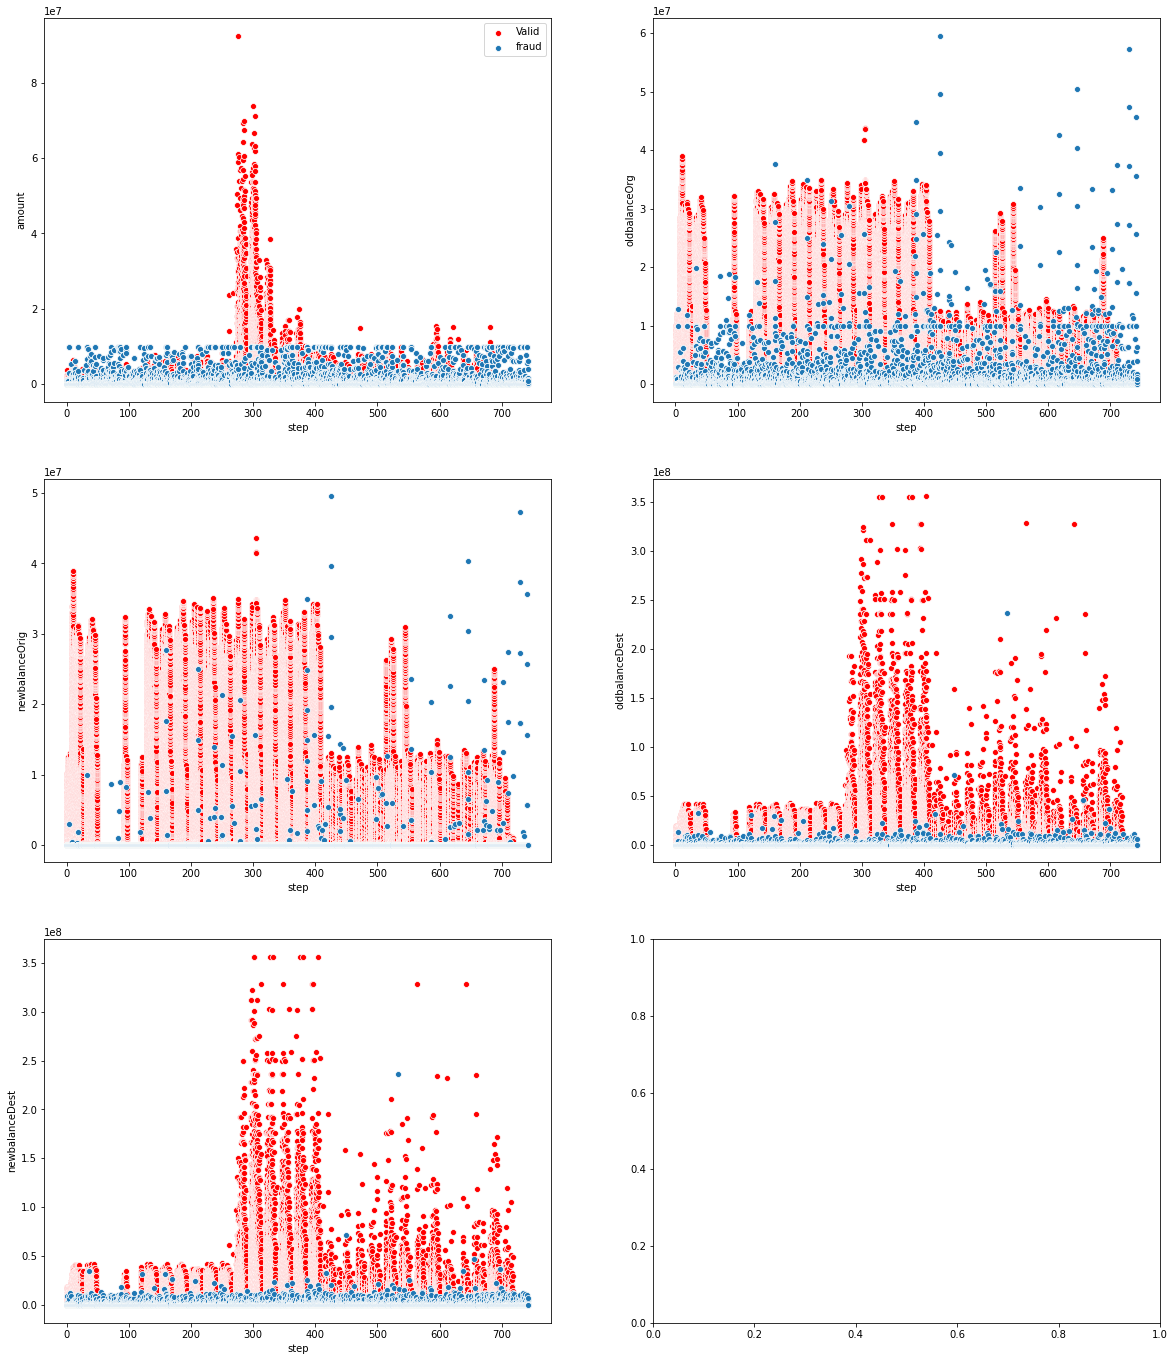

In [11]:
fig, axes = plt.subplots(3, 2, figsize=(20, 24))

valid = transactions[transactions['isFraud'] == 0]
fraud = transactions[transactions['isFraud'] == 1]
ax = axes.ravel()
features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

for i, feature in enumerate(features):
    sb.scatterplot(valid['step'], valid[feature], c=['red'], ax=ax[i])
    sb.scatterplot(fraud['step'], fraud[feature], ax=ax[i])
    ax[0].legend(["Valid", "fraud"])

Okay, the plots are also interesiting. First, the amount the distribution is kind of making a boundary by itself, the transaction amount for fraud is not more than 1X10^7-ish while the valid data could be more. Second, oldbalanceOrg it looks similar to amount but the are many data that are scattered above the fraud boundary and also the valid. Next, newbalanceOrig the plot looks like answering the previous hypotesis most of the fraud data have 0 value in it. Then, oldbalanceDest the value of fraud data is at the minimum level compare to the valid. Last, newbalanceDest similar looking like oldbalaceDest the data just at minimum level.

## Component Analysis

Above is a way to find the components that separates the valid and fraud, another way is by using decomposing method like PCA or NMF(Non Negative Matrix Factorization) since our data is postive or t-sne.

First, lets drop the type, nameOrig, nameDest, isFlag, and isFlaggedFraud

In [4]:
from sklearn.preprocessing import StandardScaler

X = transactions.drop(['type', 'nameOrig', 'nameDest', 'isFraud', 'isFlaggedFraud'], axis=1)
X_scaled = StandardScaler().fit_transform(X)

__PCA__

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

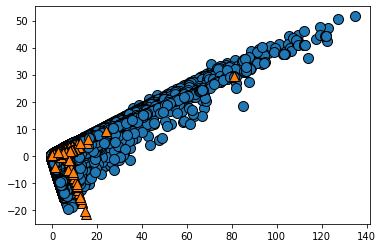

In [8]:
y = transactions['isFraud'].values
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], y);

__NMF__

In [10]:
from sklearn.decomposition import NMF

# NMF cannot have negative inputs
nmf = NMF(n_components=2)
X_nmf = nmf.fit_transform(X)

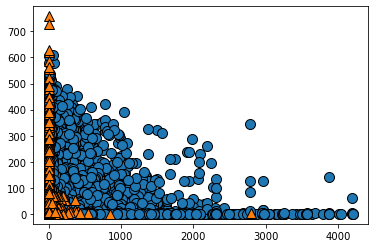

In [11]:
mglearn.discrete_scatter(X_nmf[:, 0], X_nmf[:, 1], y);

__T-SNE__

Running t-sne could take ages if feeding it with 6362620 data so lets take 1% from it just for t-sne

In [12]:
from sklearn.manifold import TSNE

sample = transactions.sample(frac=0.01, random_state=43)

X_sampled = sample.drop(['type', 'nameOrig', 'nameDest', 'isFraud', 'isFlaggedFraud'], axis=1)
y_samples = sample['isFraud']

X_scaled = StandardScaler().fit_transform(X_sampled)

tsne = TSNE()
X_tsne = tsne.fit_transform(X_scaled)

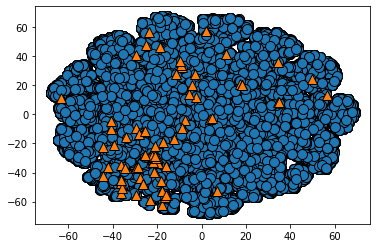

In [13]:
mglearn.discrete_scatter(X_tsne[:, 0], X_tsne[:, 1], y_samples)

PCA and NMF gives similar shape. But, T-sne on the other hand the visualization is like blob with the fraud data scattered inside the blob of valid data, maybe it's because of 1% of sample. The information we got here is with two components extracted from the datasets it all of the methods cannot separate between the frauds and valids.

## Building Models

There are some quite popular algothims which specialized for case with the target distribution data is imbalanced like isolation forest, local outlier factor(LOF), and One-Class SVM, but first we are going to try with the simplest algorithm available, like KNN, then logistic regression, and then moving up to ensemble tree.

For evaluation the metrics would be used are accuracy, f1-score, roc_auc, and get better insight into our model prediction with classification report.

In [5]:
# preparing test and train data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_raw = transactions.drop(['nameOrig', 'nameDest', 'isFraud', 'isFlaggedFraud'], axis=1)
X_type = pd.get_dummies(X_raw['type'])
y = transactions['isFraud']

# most of the algorithm would workd best
# if the data is scaled
standardScaler = StandardScaler()
X_numeric = standardScaler.fit_transform(X_raw.drop('type', axis=1))

# combine the numerical and encoded X
X = np.hstack([X_numeric, X_type])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_auc_score, roc_curve


def show_performace(y_predicted, y_train_pred, y_test, y_train):
    print("number of errors %d" % (y_predicted != y_test).sum())
    print("f1 traning score : %.3f" % f1_score(y_train, y_train_pred))
    print("f1 score : %.3f" % f1_score(y_test, y_predicted))
    print(classification_report(y_test, y_predicted, labels=[0,1]))
    print(confusion_matrix(y_test, y_predicted))
    
def show_precision_recall(y_decision, y_test):
    precision, recall, thresholds = precision_recall_curve(
                                    y_test, y_decision)

    close_zero = np.argmin(np.abs(thresholds))
    plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
    label="threshold zero", fillstyle="none", c='k', mew=2)
    plt.plot(precision, recall, label="precision recall curve")
    plt.ylabel("Recall")
    plt.xlabel("Precision")
    
def show_roc_auc_score(y_proba, y_test):
    roc_score = roc_auc_score(y_test, y_proba)
    avg_precision = average_precision_score(y_test, y_proba)
    print("AUC score %.3f" % roc_score )
    print("Average precision score %.3f" % avg_precision)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    
    # plotting the roc curve
    plt.plot(fpr, tpr, label="ROC Curve SVC")
    
    # plotting threshold
    close_zero = np.argmin(np.abs(thresholds - 0.5))
    plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
    label="threshold zero", fillstyle="none", c='k', mew=2)

    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")

__Logistic Regression__

In [10]:
lr = LogisticRegression(C=100, random_state=43, n_jobs=-1)
lr.fit(X_train, y_train)

LogisticRegression(C=100, n_jobs=-1, random_state=43)

number of errors 1111
f1 traning score : 0.631
f1 score : 0.654
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588596
           1       0.91      0.51      0.65      2059

    accuracy                           1.00   1590655
   macro avg       0.96      0.75      0.83   1590655
weighted avg       1.00      1.00      1.00   1590655

[[1588495     101]
 [   1010    1049]]
AUC score 0.990
Average precision score 0.701


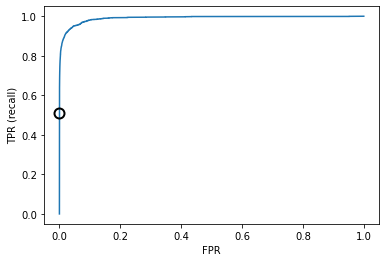

In [11]:
y_pred = lr.predict(X_test)
y_pred_train = lr.predict(X_train)
y_proba = lr.predict_proba(X_test)[:,1]

show_performace(y_pred, y_pred_train, y_test, y_train)
show_roc_auc_score(y_proba, y_test)

__Random Forest__

In [12]:
%%time
rf = RandomForestClassifier(max_depth=3, random_state=43, n_jobs=-1)
rf.fit(X_train, y_train)

Wall time: 2min 7s


RandomForestClassifier(max_depth=3, n_jobs=-1, random_state=43)

number of errors 1973
f1 traning score : 0.083
f1 score : 0.080
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588596
           1       1.00      0.04      0.08      2059

    accuracy                           1.00   1590655
   macro avg       1.00      0.52      0.54   1590655
weighted avg       1.00      1.00      1.00   1590655

[[1588596       0]
 [   1973      86]]
AUC score 0.980
Average precision score 0.727


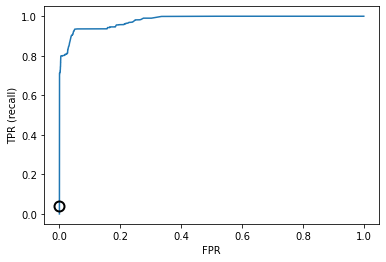

In [13]:
y_pred = rf.predict(X_test)
y_pred_train = rf.predict(X_train)
y_proba = rf.predict_proba(X_test)[:,1]

show_performace(y_pred, y_pred_train, y_test, y_train)
show_roc_auc_score(y_proba, y_test)

__Gradient Boosting__

Running Gradientboosting could take a while so this one was just interrupted.

In [14]:
%%time
gboost =  GradientBoostingClassifier(random_state=43)
gboost.fit(X_train, y_train)

KeyboardInterrupt: 

In [15]:
y_pred = gboost.predict(X_test)
y_proba = gboost.decision_function(X_test)
y_pred_train = gboost.predict(X_train)

show_performace(y_pred, y_pred_train, y_test, y_train)
show_roc_auc_score(y_proba, y_test)

AttributeError: 'NoneType' object has no attribute 'tree_'

From those three algorithms logitsic regression is the greatest of them all with f1-score is 0.65. Now let's do some feature engineering and parameter tuning.

## Feature Engineering and Parameter Tuning

### Feature Engineering

In [20]:
cash_out_transfer = transactions.loc[transactions['type'].isin(['CASH_OUT', 'TRANSFER'])].copy()
cash_out_transfer

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.0,C476402209,5083.00,51513.44,0,0
19,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0


According to previous hypotesis that the value of oldbalanceOrg in either TRANSFER or CASH_OUT type is equal to their amount, lets create a columns to store the differences from amount.

In [21]:
cash_out_transfer['amount_oldbalance_diff'] = cash_out_transfer.loc[:, 'amount'] - cash_out_transfer.loc[:, 'oldbalanceOrg']
cash_out_transfer.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,amount_oldbalance_diff
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,0.00
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,0.00
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,213808.94
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,214605.30
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,300850.89


Now, this data is going to be used as our dataset since the most type of fraud happens in either TRANSFER or CASH_OUT type.

In [22]:
X_raw = cash_out_transfer.drop(['nameOrig', 'nameDest', 'isFraud', 'isFlaggedFraud', 'type'], axis=1)
y = cash_out_transfer['isFraud']

X_type = pd.get_dummies(cash_out_transfer['type']) 

# most of the algorithm would workd best
# if the data is scaled
standardScaler = StandardScaler()
X_scaled = standardScaler.fit_transform(X_raw)

X = np.hstack([X_scaled, X_type])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43)

In [19]:
lr = LogisticRegression(C=0.001, random_state=43, n_jobs=-1)
lr.fit(X_train, y_train)

LogisticRegression(C=0.001, n_jobs=-1, random_state=43)

number of errors 1357
accuracy score 0.998041
f1 traning score : 0.498
f1 score : 0.523
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    690540
           1       0.95      0.36      0.52      2063

    accuracy                           1.00    692603
   macro avg       0.97      0.68      0.76    692603
weighted avg       1.00      1.00      1.00    692603

[[690501     39]
 [  1318    745]]


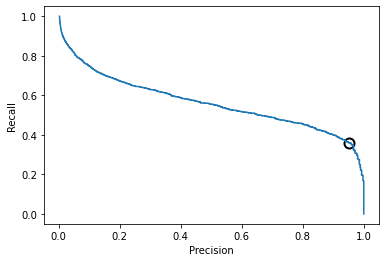

In [35]:
y_pred = lr.predict(X_test)
y_pred_train = lr.predict(X_train)
y_proba = lr.predict_proba(X_test)[:,1] - 0.5

show_performace(y_pred, y_pred_train, y_test, y_train)
show_precision_recall(y_proba, y_test)

In [30]:
%%time
rf = RandomForestClassifier(max_depth=3, random_state=43, n_jobs=-1)
rf.fit(X_train, y_train)

CPU times: user 6min 5s, sys: 2.09 s, total: 6min 7s
Wall time: 1min 36s


RandomForestClassifier(max_depth=3, n_jobs=-1, random_state=43)

number of errors 767
accuracy score 0.998893
f1 traning score : 0.781
f1 score : 0.772
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    690540
           1       1.00      0.63      0.77      2063

    accuracy                           1.00    692603
   macro avg       1.00      0.81      0.89    692603
weighted avg       1.00      1.00      1.00    692603

[[690539      1]
 [   766   1297]]


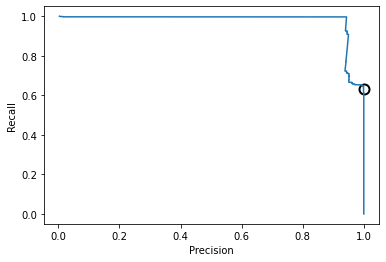

In [31]:
y_pred = rf.predict(X_test)
y_pred_train = rf.predict(X_train)
y_proba = rf.predict_proba(X_test)[:,1] - 0.5

show_performace(y_pred, y_pred_train, y_test, y_train)
show_precision_recall(y_proba, y_test)

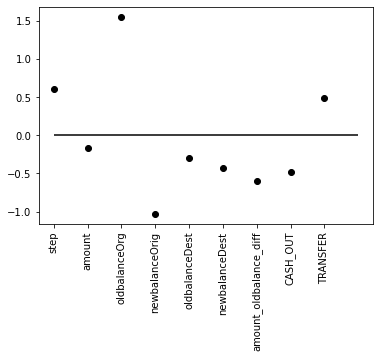

In [32]:
# visualizing the logistic regression feature coefficients
plt.plot(lr.coef_.T, 'o', c='k')
plt.hlines(0,0,9)
plt.xticks(np.arange(9), X_raw.columns.to_list() + ['CASH_OUT', 'TRANSFER'], rotation=90);

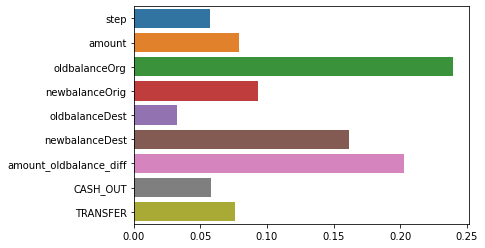

In [33]:
sb.barplot( rf.feature_importances_, X_raw.columns.to_list() + ['CASH_OUT', 'TRANSFER'])

The Logistic regression seems getting more underfit with the new feature. However, the Random forest goes up and give exciting result of f1-score 0.77 and our new features seems had been given high importances.

Next, let's try to find the sweet spots tuning for our models this time including GradientBoosting.

## Parameter Tuning

If you want to run this code, please mind that the code for searching GradientBoosting params could run for hours and computationaly expensive.

**Grid Search LogisticRegression**

In [24]:
%%time
# create grid search
from sklearn.model_selection import GridSearchCV

logreg_grid = { 'C': [1000, 100, 10, 1, .01, .001, .0001],
                'penalty': ['l2', 'l1']}

logreg_search = GridSearchCV(LogisticRegression(), logreg_grid, scoring='average_precision', n_jobs=-1, verbose=2, cv=2)
logreg_search.fit(X_train, y_train)

Fitting 2 folds for each of 14 candidates, totalling 28 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   42.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   42.3s finished


Wall time: 1min


GridSearchCV(cv=2, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1000, 100, 10, 1, 0.01, 0.001, 0.0001],
                         'penalty': ['l2', 'l1']},
             scoring='average_precision', verbose=2)

In [25]:
print("Best average-precision training score: {:.2f}".format(logreg_search.best_score_))
print("Best parameters: ", logreg_search.best_params_)
print("Test average-precision score: {:.2f}".format(logreg_search.score(X_test, y_test)))

Best average-precision training score: 0.68
Best parameters:  {'C': 1000, 'penalty': 'l2'}
Test average-precision score: 0.69


**Grid search Random forest**

In [26]:
%%time
rf_params = {
        'max_features': [9, 5, 3],
        'max_depth': [None, 5, 3]
    }

rf_search = GridSearchCV(RandomForestClassifier(), rf_params, scoring='average_precision', n_jobs=-1, verbose=2, cv=2)
rf_search.fit(X_train, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed: 30.6min remaining: 11.8min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 33.5min finished


Wall time: 53min 47s


GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 3], 'max_features': [9, 5, 3]},
             scoring='average_precision', verbose=2)

In [27]:
print("Best average-precision train score: {:.2f}".format(rf_search.best_score_))
print("Best parameters: ", rf_search.best_params_)
print("Test average-precision score: {:.2f}".format(rf_search.score(X_test, y_test)))

Best average-precision train score: 1.00
Best parameters:  {'max_depth': 5, 'max_features': 5}
Test average-precision score: 1.00


**Grid Search Gradient Boosting**

In [39]:
%%time
gboost_params = {
        'max_depth': [3, 2, 1],
        'learning_rate': [0.1, 0.001]
    }

gboost_search = GridSearchCV(GradientBoostingClassifier(), gboost_params, scoring='roc_auc', n_jobs=-1, verbose=2, cv=2)
gboost_search.fit(X_train, y_train)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:   20.0s remaining:    6.7s


KeyboardInterrupt: 

In [32]:
print("Best AUC train score: {:.2f}".format(gboost_search.best_score_))
print("Best parameters: ", gboost_search.best_params_)
print("Test AUC score: {:.2f}".format(gboost_search.score(X_test, y_test)))

Best f1-macro train set: 0.98
Best parameters:  {'learning_rate': 0.1, 'max_depth': 3}
Test set accuracy: 0.93


**Proving Ground the searches**

In [28]:
%%time
lr_best = LogisticRegression( C= 1000, penalty= 'l2', n_jobs=-1)
rf_best = RandomForestClassifier(max_depth= None, max_features= 3, n_jobs=-1)
gboost_best = GradientBoostingClassifier(learning_rate= 0.1, max_depth= 3)

lr_best.fit(X_train, y_train)
rf_best.fit(X_train, y_train)
gboost_best.fit(X_train, y_train)

Wall time: 32min 33s
Parser   : 123 ms


GradientBoostingClassifier()

In [30]:
lr_y_pred = lr_best.predict(X_test)
lr_y_pred_train = lr_best.predict(X_train)
lr_y_proba = lr_best.predict_proba(X_test)[:,1]

rf_y_pred = rf_best.predict(X_test)
rf_y_pred_train = rf_best.predict(X_train)
rf_y_proba = rf_best.predict_proba(X_test)[:,1]

gboost_y_pred = gboost_best.predict(X_test)
gboost_y_pred_train = gboost_best.predict(X_train)
gboost_y_proba = gboost_best.decision_function(X_test)

number of errors 1140
f1 traning score : 0.634
f1 score : 0.645
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    690540
           1       0.90      0.50      0.64      2063

    accuracy                           1.00    692603
   macro avg       0.95      0.75      0.82    692603
weighted avg       1.00      1.00      1.00    692603

[[690428    112]
 [  1028   1035]]
AUC score 0.980
Average precision score 0.686


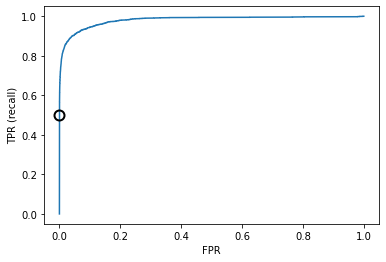

In [31]:
show_performace(lr_y_pred, lr_y_pred_train, y_test, y_train)
show_roc_auc_score(lr_y_proba, y_test)

number of errors 9
f1 traning score : 1.000
f1 score : 0.998
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    690540
           1       1.00      1.00      1.00      2063

    accuracy                           1.00    692603
   macro avg       1.00      1.00      1.00    692603
weighted avg       1.00      1.00      1.00    692603

[[690539      1]
 [     8   2055]]
AUC score 0.998
Average precision score 0.997


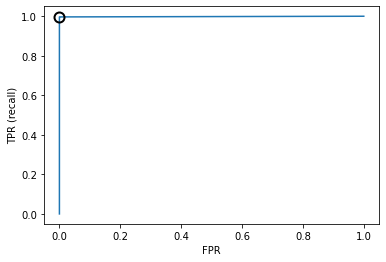

In [32]:
show_performace(rf_y_pred, rf_y_pred_train, y_test, y_train)
show_roc_auc_score(rf_y_proba, y_test)

number of errors 599
f1 traning score : 0.856
f1 score : 0.852
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    690540
           1       0.87      0.84      0.85      2063

    accuracy                           1.00    692603
   macro avg       0.93      0.92      0.93    692603
weighted avg       1.00      1.00      1.00    692603

[[690280    260]
 [   339   1724]]
AUC score 0.839
Average precision score 0.667


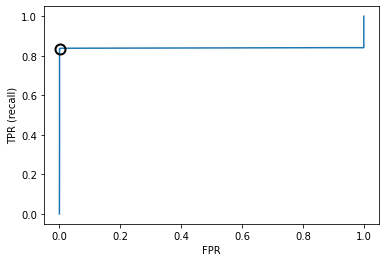

In [33]:
show_performace(gboost_y_pred, gboost_y_pred_train, y_test, y_train)
show_roc_auc_score(gboost_y_proba, y_test)

## Conclusion

With such an imbalanced data if the features are just right then the algoritm would do the rest, even with the simples one. To put on bussiness perspective looks like ROC AUC score of 0.998 is amazing and it could be the model's selling point, but it also f1-score 0.99 or 99% and average precision 0.99 or 99%. The main thing about this task is to build a model that could detect fraud and the fraud itself nearly 0.13% of total transactions in this dataset. If you build a dummy model that just guessing 0(not fraud) you could get about 87% correct but if it asked to guest fraud it could be 99% wrong.

RandomForest is the right algorithm for this case, but GradientBoosting is not bad either, although both of them were outsmarted by LogisticRegression at the first place. Tree based algorithms especially the ensembles is capable to fit into our data compared to Logistic regression, but it could be slow to train with large number of dataset remember we just train about 2,077,806 rows that's why I put some warnings.

To sum up, the lesson learned in this dataset learning was understanding the data to it's core is necessary because it maybe have some pattern that would seprate each class clearly and if finding the features seems enough then tuning the algorithm params should help solve the problem, and also start with a simplest algorithm. Then, use the proper metrics for right problem.